## Script permettant d'extraire les images du zip

In [1]:
import zipfile

with zipfile.ZipFile('data2.zip', 'r') as zip_ref:
  zip_ref.extractall()

In [2]:
!pip install pytorch-lightning albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 56.0 MB/s eta 0:00:00


In [3]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import albumentations as A
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import os

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [59]:
def rebuild_image(full_image, center_image):
    result = full_image.copy()
    result[32:96, 32:96, :] = center_image
    return result

In [6]:
import matplotlib.pyplot as plt

def load_data(data_dir):
    images_completes = []
    images_incompletes = []

    images_completes_dir = os.path.join(data_dir, "image_complète")
    images_incompletes_dir = os.path.join(data_dir, "image_incomplete")

    for file in os.listdir(images_completes_dir):
        img = cv2.imread(os.path.join(images_completes_dir, file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images_completes.append(img)

    for file in os.listdir(images_incompletes_dir):
        img = cv2.imread(os.path.join(images_incompletes_dir, file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images_incompletes.append(img)

    return images_completes, images_incompletes

In [7]:
def extract_center_image(image):
    return image[32:96, 32:96, :]

In [8]:
class ImageNetDataset(torch.utils.data.Dataset):
    def __init__(self, image_full, center_image, transform=None):
        self.image_full = image_full
        self.center_image = center_image
        self.transform = transform

    def __len__(self):
        return len(self.image_full)

    def __getitem__(self, idx):
        image_full = self.image_full[idx]
        center_image = self.center_image[idx]

        if self.transform:
            image_full = self.transform(image_full)
            center_image = self.transform(center_image)

        return image_full, center_image

In [9]:
class ImageNetDataModule(pl.LightningDataModule):
    def __init__(self, batch_size = 64):
        super().__init__()
        self.train_data_dir = 'data2/train/'
        self.val_data_dir = 'data2/validation/'
        self.test_data_dir = 'data2/test/'
        # self.predict_data_dir = 'data/'
        self.batch_size_train, self.batch_size_valid, self.batch_size_test = batch_size,batch_size,batch_size
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')        # Supprimer après

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float)
        ])


    def setup(self, stage):

        if stage == "fit" or stage is None:
            images_completes_train, images_incompletes_train = load_data(self.train_data_dir)
            images_completes_valid, images_incompletes_valid = load_data(self.val_data_dir)

            center_image_train = [extract_center_image(img) for img in images_completes_train]
            center_image_valid = [extract_center_image(img) for img in images_completes_valid]

            self.imagenet_train = ImageNetDataset(images_incompletes_train, center_image_train, transform=self.transform)
            self.imagenet_valid = ImageNetDataset(images_incompletes_valid, center_image_valid, transform=self.transform)


        if stage == "test" or stage is None:
            images_complètes_test, images_incomplètes_test = load_data(self.test_data_dir)

            center_image_test = [extract_center_image(img) for img in images_complètes_test]

            self.imagenet_test = ImageNetDataset(images_incomplètes_test, center_image_test, transform=self.transform)

        # if stage == "predict" or stage is None:
        #     # LOAD DATA
        #     self.imagenet_predict = ...


    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(self.imagenet_train, batch_size=self.batch_size_train, shuffle=True)
        return train_loader

    # def val_dataloader(self):
    #     val_loader = torch.utils.data.DataLoader(self.imagenet_valid, batch_size=self.batch_size_valid, shuffle=False)
    #     return val_loader

    def test_dataloader(self):
        test_loader = torch.utils.data.DataLoader(self.imagenet_test, batch_size=self.batch_size_test, shuffle=False)
        return test_loader

    # def predict_dataloader(self):
    #     predict_loader = torch.utils.data.DataLoader(self.imagenet_predict, batch_size=self.batch_size_test, shuffle=False)
    #     return predict_loader

In [10]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, learning_rate=0.2, inplace=True):
        super(EncoderBlock, self).__init__()

        self.encoderblock = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(learning_rate, inplace),
        )

    def forward(self, x):
        return self.encoderblock(x)

In [11]:
# CHANGER PARAMETRES D'ENTREE QUAND ON AURA OPTIMISER LA FONCTION

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, True),
            # EncoderBlock(64, 64),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),
            # EncoderBlock(64, 128),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, True),
            # EncoderBlock(128, 256),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, True),
            # EncoderBlock(256, 512),

            # '''On ne peut pas faire ça sinon taille de l'image = 2*2'''
            # # Todo: à voir si on la garde ou non, dans l'article ils disent qu'ils en ont utilisé une, mais pas dans le code
            # nn.MaxPool2d(kernel_size=2, stride=2),
        )



    def forward_encoder(self, x):
        x = self.encoder(x)

        return x

In [12]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, inplace=True):
        super(DecoderBlock, self).__init__()

        self.decoderblock = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace),
        )

    def forward(self, x):
        return self.decoderblock(x)

In [13]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.decoder = nn.Sequential(

            nn.ConvTranspose2d(4000, 512, kernel_size=4),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # DecoderBlock(512, 256),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # DecoderBlock(256, 128),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # DecoderBlock(128, 64),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            # Dans leur code, il n'y a pas de couche BatchNorm2d et de ReLU après la dernière couche ConvTranspose2d
            # nn.BatchNorm2d(3),
            # nn.ReLU(True),

            # Fonction d'activation finale permettant de normaliser les valeurs entre -1 et 1, présente dans le code mais pas dans l'article
            nn.Tanh()
        )



    def forward_decoder(self, x):
        x = self.decoder(x)

        return x

In [14]:
class Bottleneck(nn.Module):
    def __init__(self):
        super(Bottleneck, self).__init__()

        # A VOIR SI ON AJOUTE LE NOISEGEN

        self.bottleneck = nn.Sequential(
            # Couche permettant de passer à l'étape "Channel-wise fully-connected layer"
            nn.Conv2d(512, 4000, kernel_size=4),
            nn.LeakyReLU(0.2, True),
        )

    def forward_bottleneck(self, x):
        x = self.bottleneck(x)

        return x

In [15]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.encoder = Encoder()
        self.bottleneck = Bottleneck()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder.forward_encoder(x)
        x = self.bottleneck.forward_bottleneck(x)
        x = self.decoder.forward_decoder(x)

        return x


# Tester la classe Generator
model = Generator()
x = torch.randn(1, 3, 128, 128)     #Créer un tensor
output = model(x)

print(f"Input {x.shape}")
print(f"Output {output.shape}")

Input torch.Size([1, 3, 128, 128])
Output torch.Size([1, 3, 64, 64])


In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.discriminator = nn.Sequential(

            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, True),
            # EncoderBlock(3, 64),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),
            # EncoderBlock(64, 128),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, True),
            # EncoderBlock(128, 256),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, True),

            # EncoderBlock(256, 512),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()

        )

    def forward(self, x):
        x = self.discriminator(x)
        x = x.view(x.size(0), -1)

        return x

In [17]:
class GeneratorModule(pl.LightningModule):
    def __init__(self, lambda_rec = 0.999, lambda_adv = 0.001):
        super(GeneratorModule, self).__init__()

        self.automatic_optimization = False

        self.generator = Generator()
        self.discriminator = Discriminator()

        self.lambda_rec = lambda_rec
        self.lambda_adv = lambda_adv

        # A REVOIR
        # DANS LEUR CODE, ILS ONT MIS CA, MAIS PAS DANS L'ARTICLE
        # DANS L'ARTICLE, ILS UTILISENT DES LOSS LEGEREMENT DIFFERENTES, QUI PERMETTENT D'AVOIR DE LA PONDÉRATION
        self.criterion_rec = nn.MSELoss()
        self.criterion_adv = nn.BCELoss()

    def forward(self, x):
        return self.generator(x)

    def configure_optimizers(self):
        optimizerD = torch.optim.Adam(self.discriminator.parameters(), lr = 0.0002, betas = (0.5, 0.999))
        optimizerG = torch.optim.Adam(self.generator.parameters(), lr = 0.002, betas = (0.5, 0.999))
        return [optimizerD, optimizerG], []

    def training_step(self, batch, batch_idx):
        full_images, center_images = batch
        batch_size = full_images.size(0)

        # valid = torch.ones(batch_size, 1)
        # fake = torch.zeros(batch_size, 1)
        valid = torch.ones(batch_size, 1, device=device)        # Supprimer après
        fake = torch.zeros(batch_size, 1, device=device)        # Supprimer après


        optimizerD, optimizerG = self.optimizers()


        # RAJOUTER DU BRUIT ? AMELIORE L'ENTRAINEMENT ?
        # --> z = torch.randn(batch_size, 100, 1, 1, device=self.device)
        # --> fake = self.generator(z)
        # CAS DISCRIMINATOR
        fake_images = self.generator(full_images)

        pred_discriminator = self.discriminator(center_images)
        fake_discriminator = self.discriminator(fake_images.detach())

        real_loss = self.criterion_adv(pred_discriminator, valid)
        fake_loss = self.criterion_adv(fake_discriminator, fake)

        # VOIR COMMENT EXPLIQUER CETTE LOSS ? EST CE QU'ELLE EST DANS LE PAPIER ?
        d_loss = (real_loss + fake_loss) / 2

        optimizerD.zero_grad()
        self.manual_backward(d_loss)
        optimizerD.step()

        # CAS GENERATOR
        fake_images = self.generator(full_images)

        pred_discriminator = self.discriminator(fake_images)

        loss_rec = self.criterion_rec(fake_images, center_images)
        loss_adv = self.criterion_adv(pred_discriminator, valid)

        joint_loss = loss_rec*self.lambda_rec + loss_adv*self.lambda_adv

        optimizerG.zero_grad()
        self.manual_backward(joint_loss)
        optimizerG.step()

        self.log('d_loss', d_loss, prog_bar=True)
        self.log('joint_loss', joint_loss, prog_bar=True)

        return {'d_loss': d_loss, 'joint_loss': joint_loss}

    def test_step(self, batch, batch_idx):
        full_images, center_images = batch
        batch_size = full_images.size(0)
        valid = torch.ones(batch_size, 1)

        fake_images = self.generator(full_images)

        pred_discriminator = self.discriminator(fake_images)

        loss_rec = self.criterion_rec(fake_images, center_images)
        loss_adv = self.criterion_adv(pred_discriminator, valid)

        joint_loss = loss_rec*self.lambda_rec + loss_adv*self.lambda_adv

        self.log('joint_loss', joint_loss, prog_bar=True)

        return joint_loss

    # AJOUTER validation_step ?
    # AJOUTER prediction_step ?

In [18]:
def display_examples(model, dataloader, num_examples = 5):
    model.eval()
    with torch.no_grad():
        for full_image, center_image in dataloader:

            center_pred = model(full_image)

            for i in range(num_examples):

                full_image_true = rebuild_image(full_image[i], center_image[i])
                full_image_pred = rebuild_image(full_image[i], center_pred[i])

                plt.figure(figsize=(10, 5))

                plt.subplot(1, 2, 1)
                plt.imshow(full_image_true)
                plt.title("True Image")

                plt.subplot(1, 2, 2)
                plt.imshow(full_image_pred)
                plt.title("Fake Image")

                plt.show()

            break

In [19]:
def save_images(model, dataloader, output_dir = 'output_directory'):
    model.eval()

    os.makedirs(output_dir, exist_ok=True)

    with torch.no_grad():
        for full_image, _ in dataloader:

            center_pred = model(full_image)

            for i in range(full_image.size(0)):

                full_image_pred = rebuild_image(full_image[i], center_pred[i])

                cv2.imwrite(f"{output_dir}/fake_image_{i}.jpg", cv2.cvtColor(full_image_pred, cv2.COLOR_RGB2BGR))

In [20]:
batch_size = 64
max_epochs = 300

train_loader = ImageNetDataModule(batch_size)

In [21]:
# Initialisation du modèle
model = GeneratorModule()

# Entrainement du modèle
trainer = pl.Trainer(max_epochs=max_epochs, devices=-1)
trainer.fit(model, train_loader)

trainer.save_checkpoint("/content/model/model.ckpt")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 71.1 M | train
1 | discriminator | Discriminator | 2.8 M  | train
2 | criterion_rec | MSELoss       | 0      | train
3 | criterion_adv | BCELoss       | 0      | train
--------------------------------------------------------
73.9 M    Trainable params
0         Non-trainable params
73.9 M    Total params
295.553   Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loop

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.


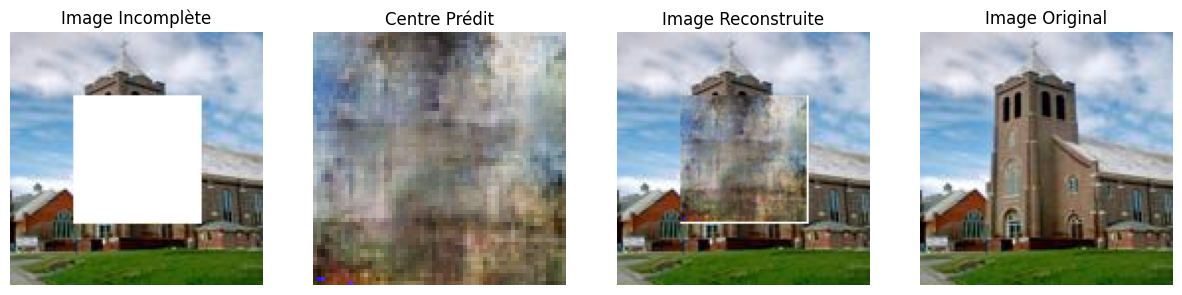

In [63]:
import torch
import cv2
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load your image
img_incomplete = "/content/data2/test/image_incomplete/church11.jpg"
img_complete = "/content/data2/test/image_complète/church11.jpg"

img_incomplete = cv2.imread(img_incomplete)
img_complete = cv2.imread(img_complete)

img_incomplete = cv2.cvtColor(img_incomplete, cv2.COLOR_BGR2RGB)
img_complete = cv2.cvtColor(img_complete, cv2.COLOR_BGR2RGB)

initial_img = img_incomplete.copy()


# Preprocess the image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])


img_incomplete = transform(img_incomplete).unsqueeze(0).to(device)

model = GeneratorModule.load_from_checkpoint("/content/model/model.ckpt").to(device)


model.eval()

# Prédiction
with torch.no_grad():
    predicted_center = model(img_incomplete)


predicted_center_np = predicted_center[0].cpu().permute(1, 2, 0).numpy()
predicted_center_np = (predicted_center_np * 255).astype(np.uint8)


# Reconstruire l'image complète
result_image = rebuild_image(initial_img, predicted_center_np)


plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(initial_img)
plt.title("Image Incomplète")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(predicted_center_np)
plt.title("Centre Prédit")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(result_image)
plt.title("Image Reconstruite")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(img_complete)
plt.title("Image Original")
plt.axis('off')

plt.show()
